In [1]:
import IPython.display as ipd
import torch
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import torch.nn.functional as F
import librosa.output
from matplotlib import cm
import matplotlib
import mir_eval
from sdr import GetSDR, compute_measures

/homes/grail/vjayaram/.local/lib/python3.6/site-packages/pkg_resources/__init__.py:1908: UserWarning: /homes/grail/vjayaram/.local/lib/python3.6/site-packages/._wrapt-1.11.2-py3.6.egg-info could not be properly decoded in UTF-8
  warnings.warn(msg)
/homes/grail/vjayaram/.local/lib/python3.6/site-packages/pkg_resources/__init__.py:1908: UserWarning: /homes/grail/vjayaram/.local/lib/python3.6/site-packages/._termcolor-1.1.0-py3.6.egg-info could not be properly decoded in UTF-8
  warnings.warn(msg)
/homes/grail/vjayaram/.local/lib/python3.6/site-packages/pkg_resources/__init__.py:1908: UserWarning: /homes/grail/vjayaram/.local/lib/python3.6/site-packages/._librosa-0.7.0-py3.6.egg-info could not be properly decoded in UTF-8
  warnings.warn(msg)
/homes/grail/vjayaram/.local/lib/python3.6/site-packages/pkg_resources/__init__.py:1908: UserWarning: /homes/grail/vjayaram/.local/lib/python3.6/site-packages/._audioread-2.1.8-py3.6.egg-info could not be properly decoded in UTF-8
  warnings.warn(ms

In [2]:
matplotlib.style.use('ggplot')
np.random.seed(123)
SAMPLE_RATE=22050

In [3]:
from data import SpatialAudioDatasetWaveform, RealDataset, MixedDataset
from network import center_trim, Demucs

In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [5]:
# fg_file = '/projects/grail/vjayaram/DinTaiFung/dataset_generators/harry_potter_10min_16b.wav'
#data_dir_real = '/projects/grail/audiovisual/datasets/DinTaiFung/2mics_real_vctk_recorded/test/'
#data_dir = '/projects/grail/audiovisual/datasets/DinTaiFung/2mics_real_samples_synthetic_composite/train/'
#data_test = RealDataset(data_dir_real, sr=SAMPLE_RATE, short_data=True)

data_dir_synth = "/projects/grail/audiovisual/datasets/DinTaiFung/pyroom_6mics_multiplevoices/test"
data_test = SpatialAudioDatasetWaveform(data_dir_synth, n_mics=6, sr=SAMPLE_RATE, target_fg_std=None, target_bg_std=None)

#data_test = MixedDataset(data_dir_synth, data_dir_real, 1000, sr=SAMPLE_RATE, perturb_prob=0.0, short_data=True)
device = torch.device('cuda:0')

In [13]:
kwargs = {
    'num_workers': 0,
    'pin_memory': True
}

In [7]:
import torch
print(torch.rand(1, device="cuda"))

tensor([0.3763], device='cuda:0')


In [18]:
test_loader = torch.utils.data.DataLoader(data_test,
                                          batch_size=32,
                                          shuffle=False,
                                          **kwargs)

In [9]:
%ls checkpoints/pyroom_synthetic_2voices_6mics_22050_augmentation/

pyroom_synthetic_2voices_6mics_22050_augmentation_0.pt
pyroom_synthetic_2voices_6mics_22050_augmentation_10.pt
pyroom_synthetic_2voices_6mics_22050_augmentation_11.pt
pyroom_synthetic_2voices_6mics_22050_augmentation_12.pt
pyroom_synthetic_2voices_6mics_22050_augmentation_13.pt
pyroom_synthetic_2voices_6mics_22050_augmentation_14.pt
pyroom_synthetic_2voices_6mics_22050_augmentation_15.pt
pyroom_synthetic_2voices_6mics_22050_augmentation_16.pt
pyroom_synthetic_2voices_6mics_22050_augmentation_17.pt
pyroom_synthetic_2voices_6mics_22050_augmentation_18.pt
pyroom_synthetic_2voices_6mics_22050_augmentation_19.pt
pyroom_synthetic_2voices_6mics_22050_augmentation_1.pt
pyroom_synthetic_2voices_6mics_22050_augmentation_20.pt
pyroom_synthetic_2voices_6mics_22050_augmentation_21.pt
pyroom_synthetic_2voices_6mics_22050_augmentation_22.pt
pyroom_synthetic_2voices_6mics_22050_augmentation_23.pt
pyroom_synthetic_2voices_6mics_22050_augmentation_24.pt
pyroom_synthetic_2voices_6mics_22050_augmentation_

In [10]:
model = Demucs(sources=2, n_audio_channels=6)

In [11]:
model.load_state_dict(torch.load('checkpoints/pyroom_synthetic_2voices_6mics_22050_augmentation/pyroom_synthetic_2voices_6mics_22050_augmentation_47.pt'))
#model.load_state_dict(torch.load('checkpoints/vctk_real_recording_22050_mixed/vctk_real_recording_22050_mixed_2.pt'))
#model.load_state_dict(torch.load('checkpoints/vctk_real_recording_3200_new_mics/vctk_real_recording_3200_new_mics_24.pt'))
#model.load_state_dict(torch.load('checkpoints/pyroom_synthetic_3voices_22050/pyroom_synthetic_3voices_22050_22.pt'))
# model.load_state_dict(torch.load('checkpoints/vctk_real_recording_22050_multiplevoices/vctk_real_recording_22050_multiplevoices_7.pt'))
model.train = False
model.to(device)

Demucs(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv1d(6, 64, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (1): Sequential(
      (0): Conv1d(64, 128, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (2): Sequential(
      (0): Conv1d(128, 256, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (3): Sequential(
      (0): Conv1d(256, 512, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (4): Sequential(
      (0): Conv1d(512, 1024, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(1024, 2048, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (5): Sequential(
      (0): Conv1d(1024

In [19]:
np.random.seed(123)
with torch.no_grad():
    #for batch_idx, (type_name, (data, label_voice_signals)) in enumerate(test_loader):
    for batch_idx, (data, label_voice_signals) in enumerate(test_loader):
        import pdb
        pdb.set_trace()
        print(batch_idx)
        if batch_idx != 0: continue
#         data = label_bg_signals[:,0,:,:]
        data = data.to(device)
        label_voice_signals = label_voice_signals.to(device)

        # Normalize input
        data_transformed = (data * 2**15).round() / 2**15
        ref = data_transformed.mean(0)
        print("Ref mean {}, ref std {}".format(ref.mean(), ref.std()))
        # ref_mean = -0.00035191531060263515  # From synthetic dataset
        # ref_std = 0.044271234422922134
        data_transformed = (data_transformed - ref.mean()) / (ref.std())

        # Run through the model
        valid_length = model.valid_length(data_transformed.shape[-1])
        delta = valid_length - data_transformed.shape[-1]
        padded = F.pad(data_transformed, (delta // 2, delta - delta // 2))

        output_signal, output_locs = model(padded)
        output_signal = center_trim(output_signal, data_transformed)
        output_locs = center_trim(output_locs, data_transformed)
        
        output_signal = output_signal * ref.std() + ref.mean()
        output_voices = output_signal[:, 0]

        break

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
> <ipython-input-19-06b4aaebbc86>(7)<module>()
-> print(batch_idx)
(Pdb) c
0
Ref mean -4.3214040488237515e-05, ref std 0.022471869364380836


In [20]:
print(output_voices.shape)
print(label_voice_signals.shape)
for i in range(32):
    print("----------------")
    #print(type_name[i])
    print("idx {} loss {}".format(i, model.voice_loss(output_voices[i], label_voice_signals[i, 0])[0]))
    #import pdb
    #pdb.set_trace()
    #input_sdr, input_sir, input_sar, input_perm = mir_eval.separation.bss_eval_sources(label_voice_signals[i, 0].cpu().numpy(), data[i].cpu().numpy(), compute_permutation=False)
    #output_sdr, output_sir, output_sar, output_perm = mir_eval.separation.bss_eval_sources(label_voice_signals[i, 0].cpu().numpy(), output_voices[i].cpu().numpy(), compute_permutation=False)
    #print("idx {} input SDR {} output SDR {}".format(i, input_sdr, output_sdr))

torch.Size([32, 6, 66150])
torch.Size([32, 1, 6, 66150])
----------------
idx 0 loss 0.00722082844004035
----------------
idx 1 loss 0.015661610290408134
----------------
idx 2 loss 0.003200676292181015
----------------
idx 3 loss 0.0035174000076949596
----------------
idx 4 loss 0.008850335143506527
----------------
idx 5 loss 0.010221341624855995
----------------
idx 6 loss 0.009398965165019035
----------------
idx 7 loss 0.007158006075769663
----------------
idx 8 loss 0.006290224380791187
----------------
idx 9 loss 0.0036058779805898666
----------------
idx 10 loss 0.006076863966882229
----------------
idx 11 loss 0.00671784533187747
----------------
idx 12 loss 0.004068135749548674
----------------
idx 13 loss 0.003764814231544733
----------------
idx 14 loss 0.012454940006136894
----------------
idx 15 loss 0.010598077438771725
----------------
idx 16 loss 0.015124157071113586
----------------
idx 17 loss 0.017442572861909866
----------------
idx 18 loss 0.013403434306383133
---

In [116]:
idx = 5
inputs = data[idx,:,:].cpu().detach().numpy()

In [117]:
label_voices = label_voice_signals[idx,:,:].cpu().detach().numpy()

In [118]:
output_voice_signals = output_voices[idx,:,:].cpu().detach().numpy()
print(output_voice_signals.shape)

(6, 66150)


In [119]:
ipd.Audio(data=(inputs[0]), rate=SAMPLE_RATE, normalize=False)

In [120]:
ipd.Audio(data=(label_voices[0]), rate=SAMPLE_RATE, normalize=False)

In [121]:
ipd.Audio(data=output_voice_signals[0], rate=SAMPLE_RATE, normalize=True)

In [115]:
def correlations(data):
    correlations = []
    for offset in range(-100, 100, 1):
        correlation = np.mean((np.roll(data[0], offset) - data[1])**2)
        correlations.append(correlation)
    return np.argmin(correlations)

In [ ]:
ipd.Audio(data=(output_bg_signals[0]), rate=22050, normalize=True)

In [60]:
from librosa.core import stft, istft
from librosa.display import specshow

In [61]:
y = inputs[0]

[]

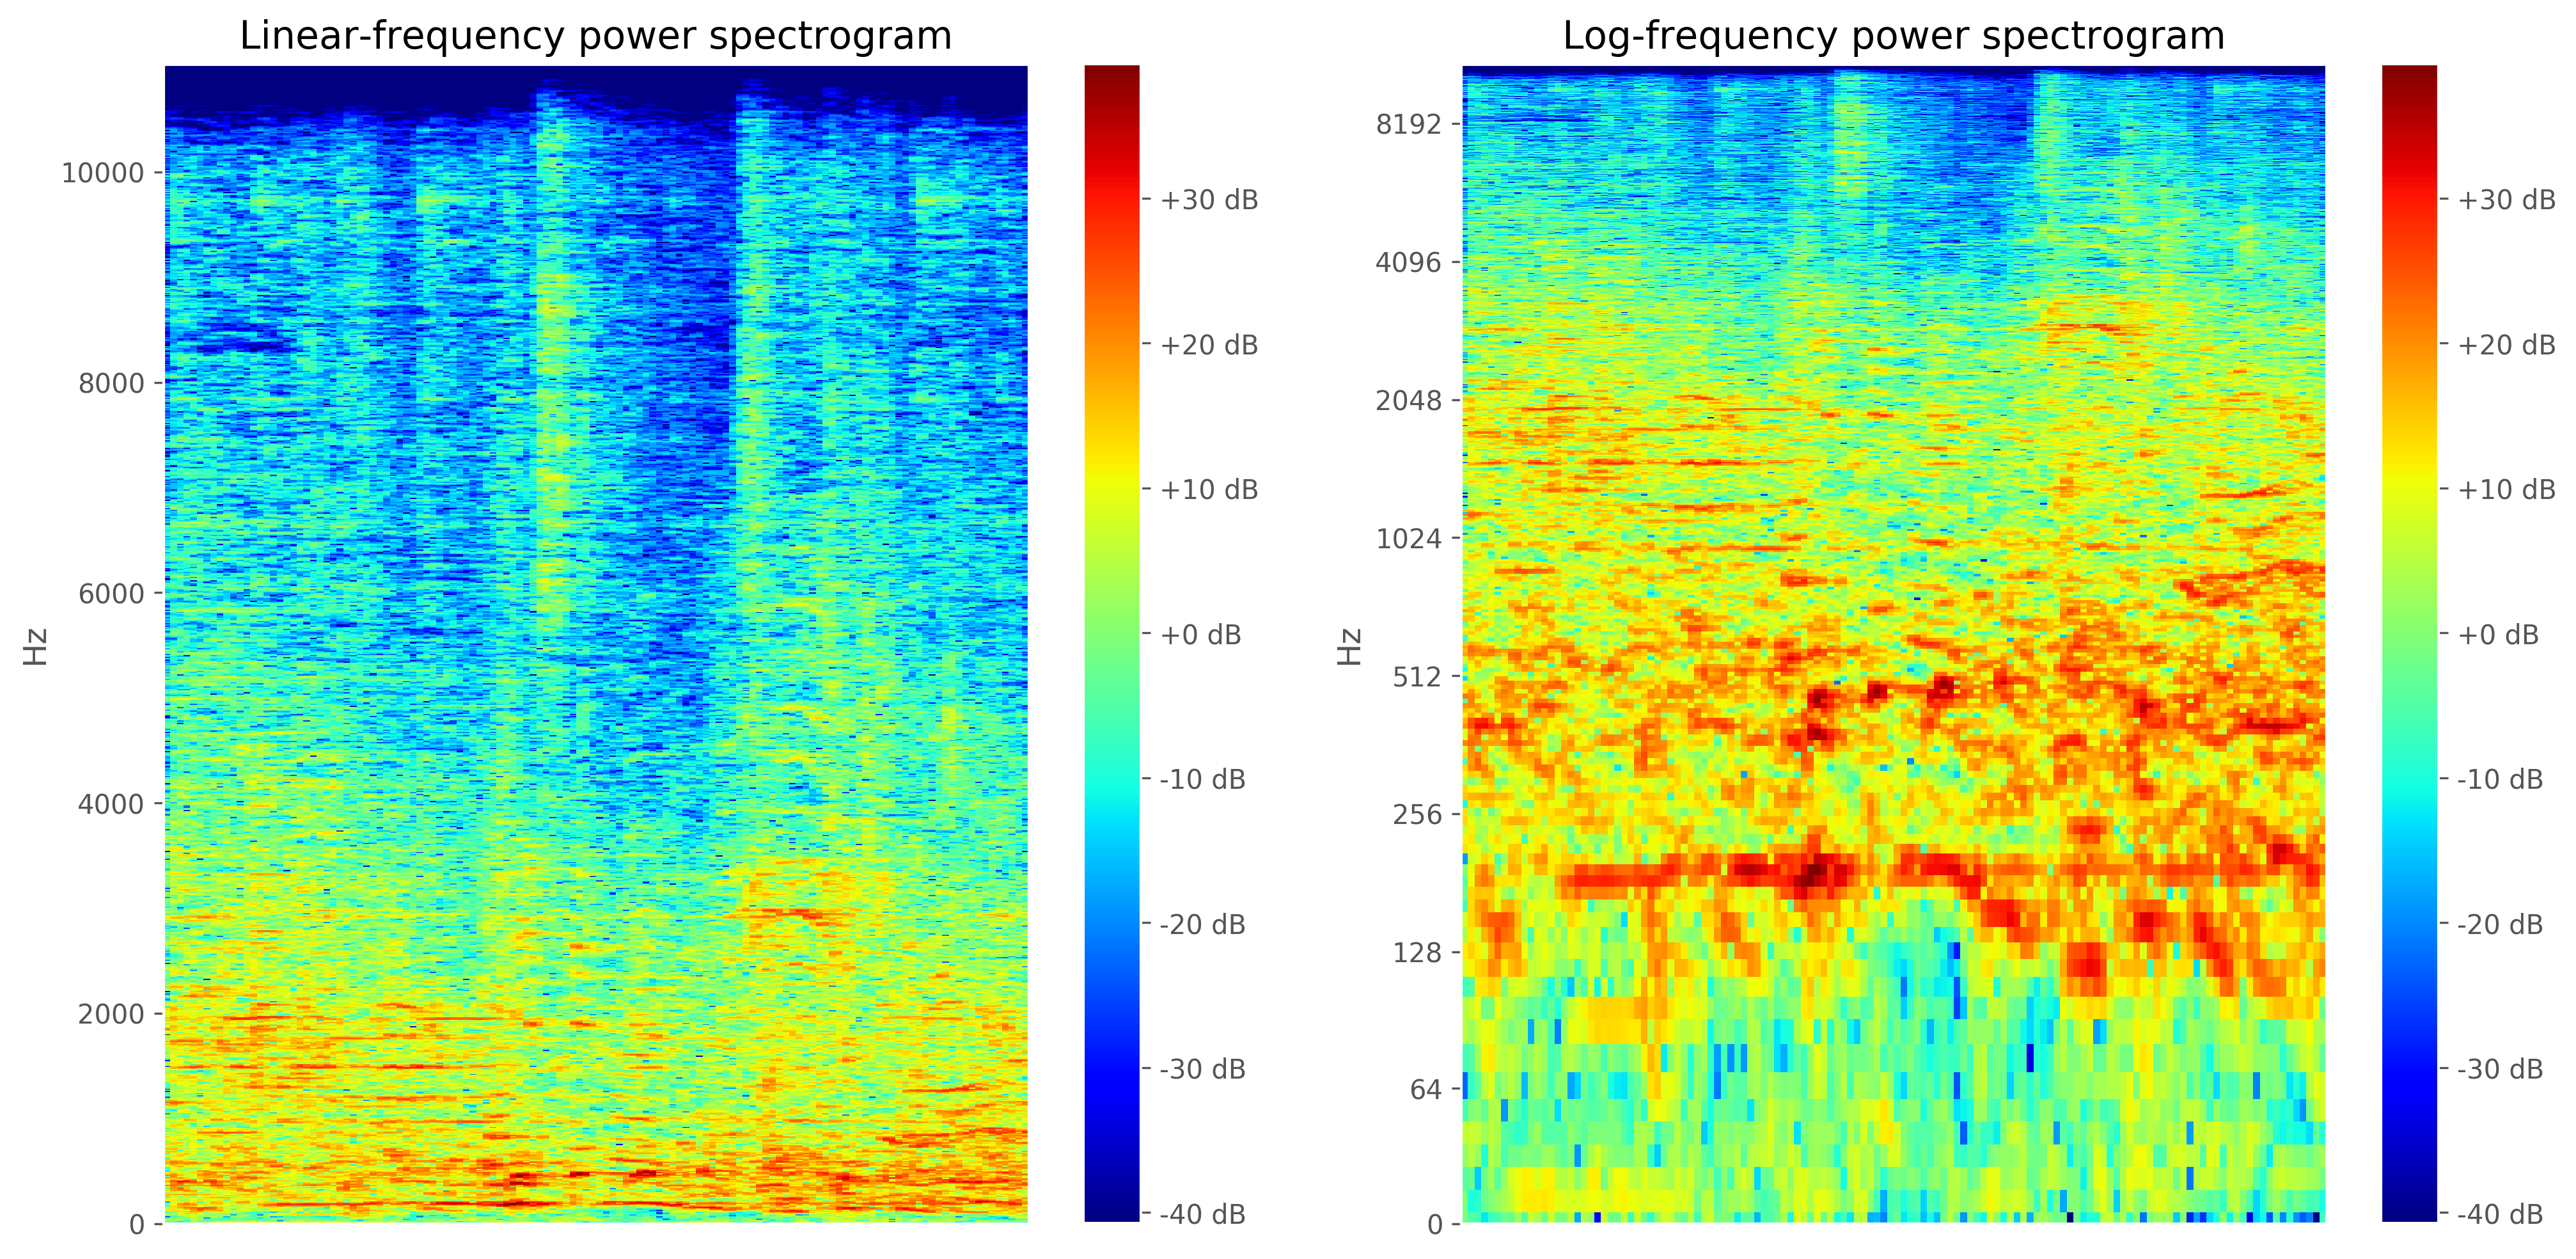

In [62]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=1.0)
plt.figure(figsize=(16, 8), dpi=300)
plt.subplot(1, 2, 1)
specshow(D, y_axis='linear', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.subplot(1, 2, 2)
specshow(D, y_axis='log', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.plot()

In [63]:
y = output_voice_signals.mean(0)

[]

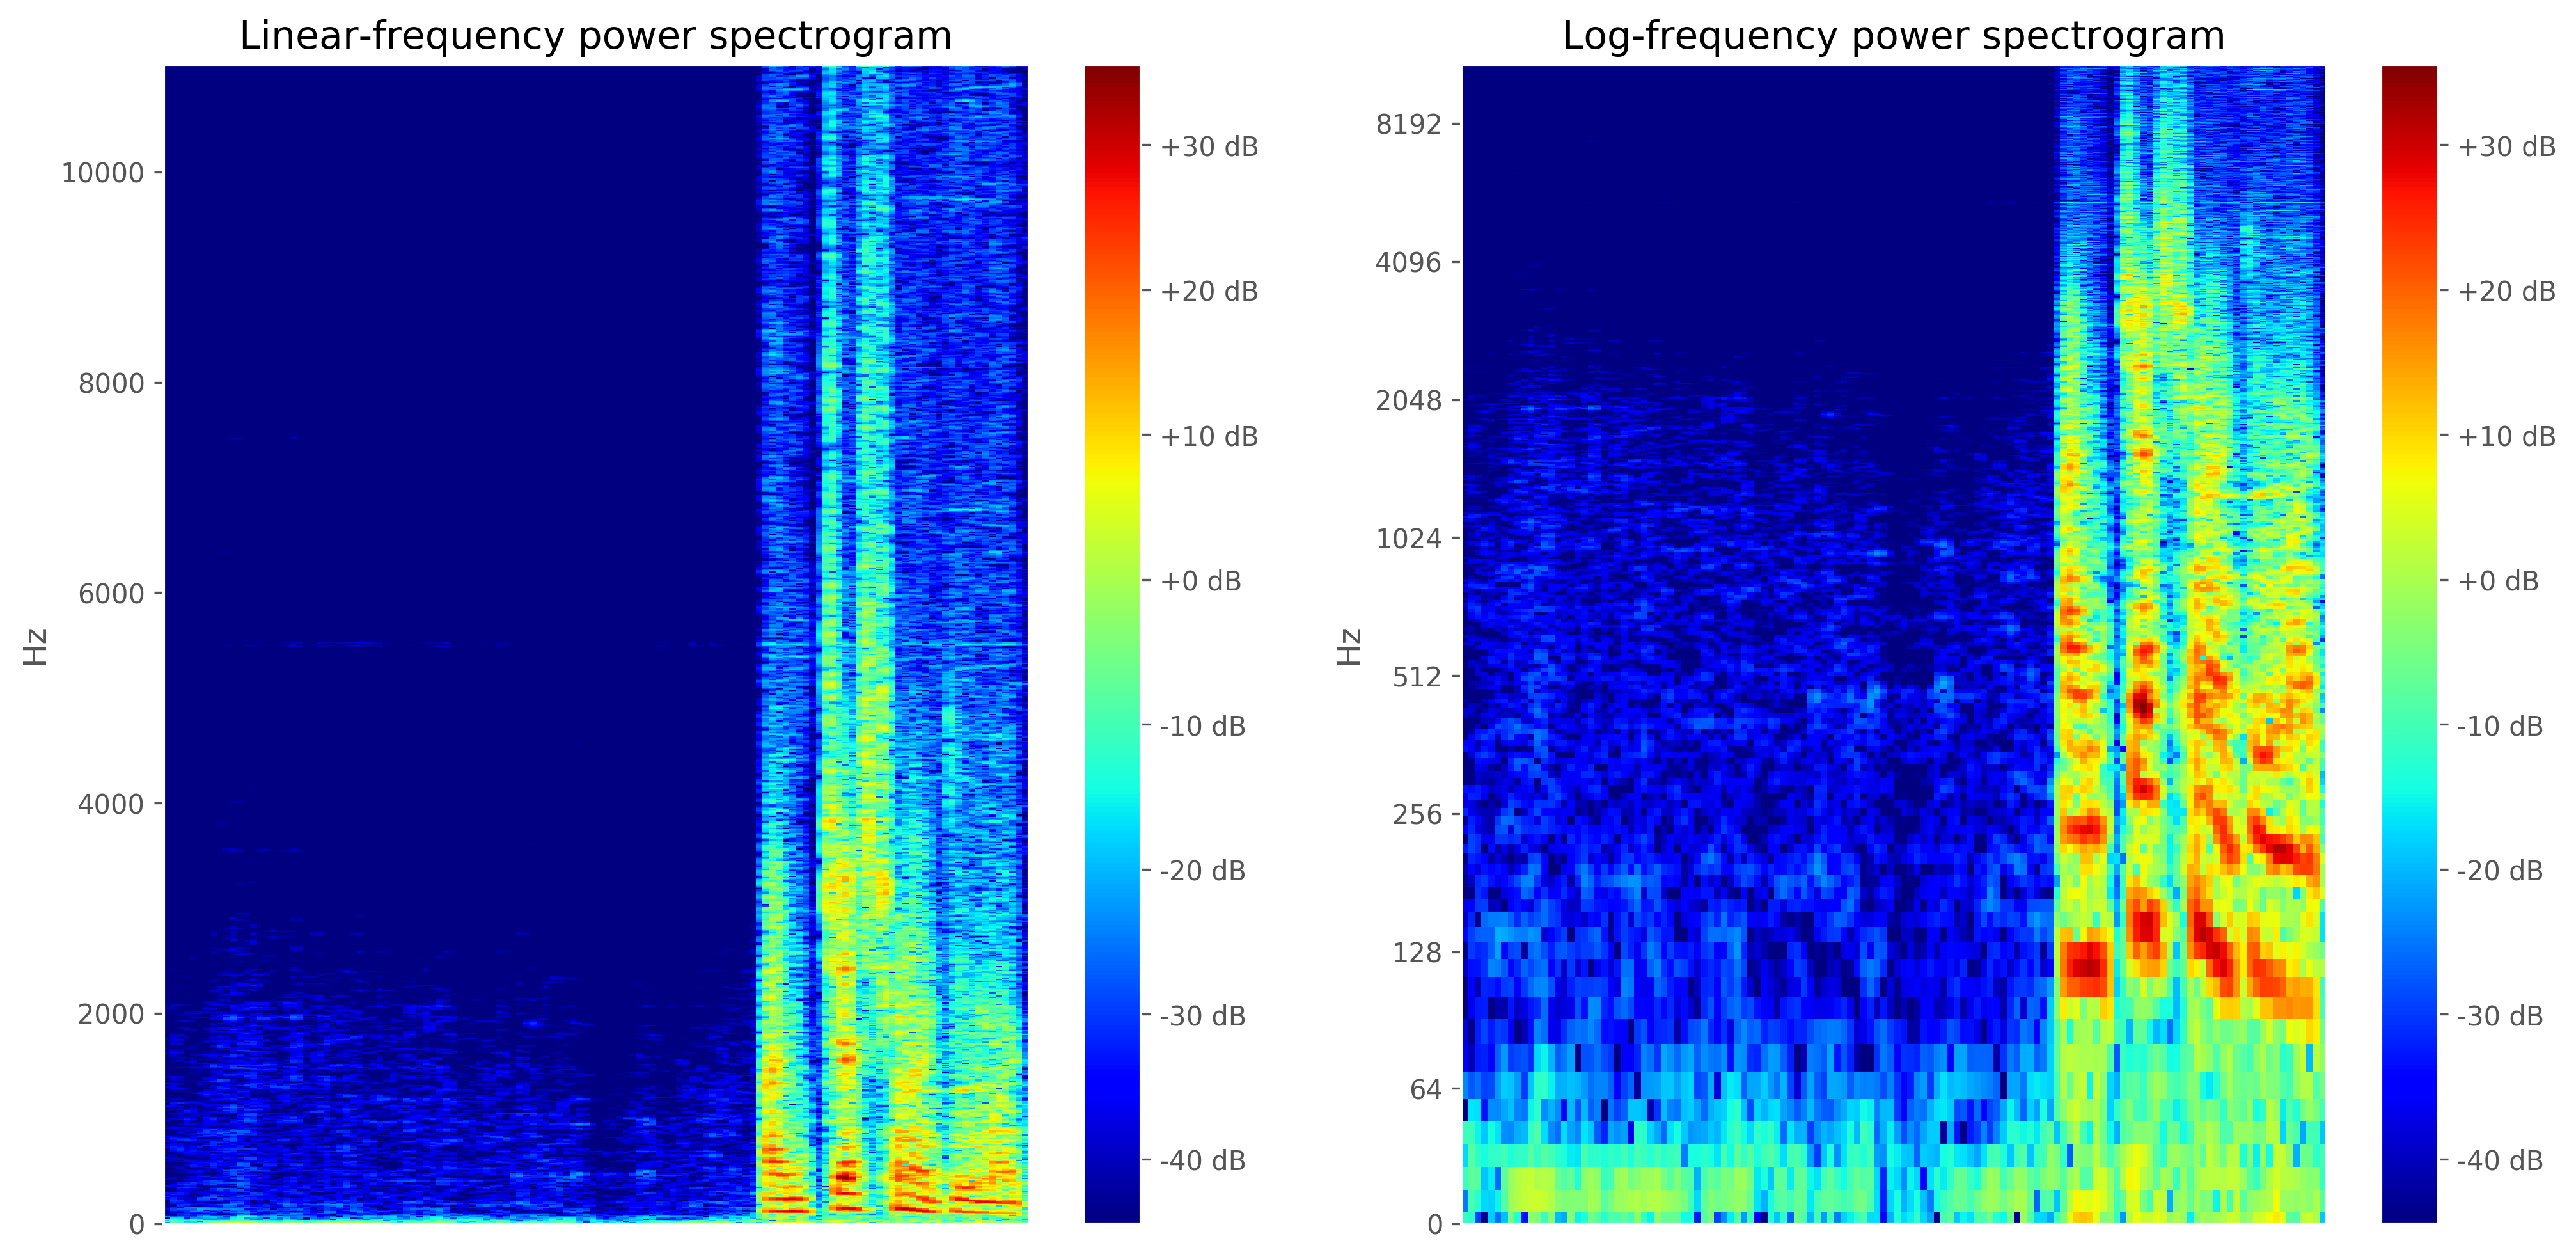

In [64]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=1.0)
plt.figure(figsize=(16, 8), dpi=300)
plt.subplot(1, 2, 1)
specshow(D, y_axis='linear', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.subplot(1, 2, 2)
specshow(D, y_axis='log', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.plot()

In [65]:
y = label_voices[0][0]

[]

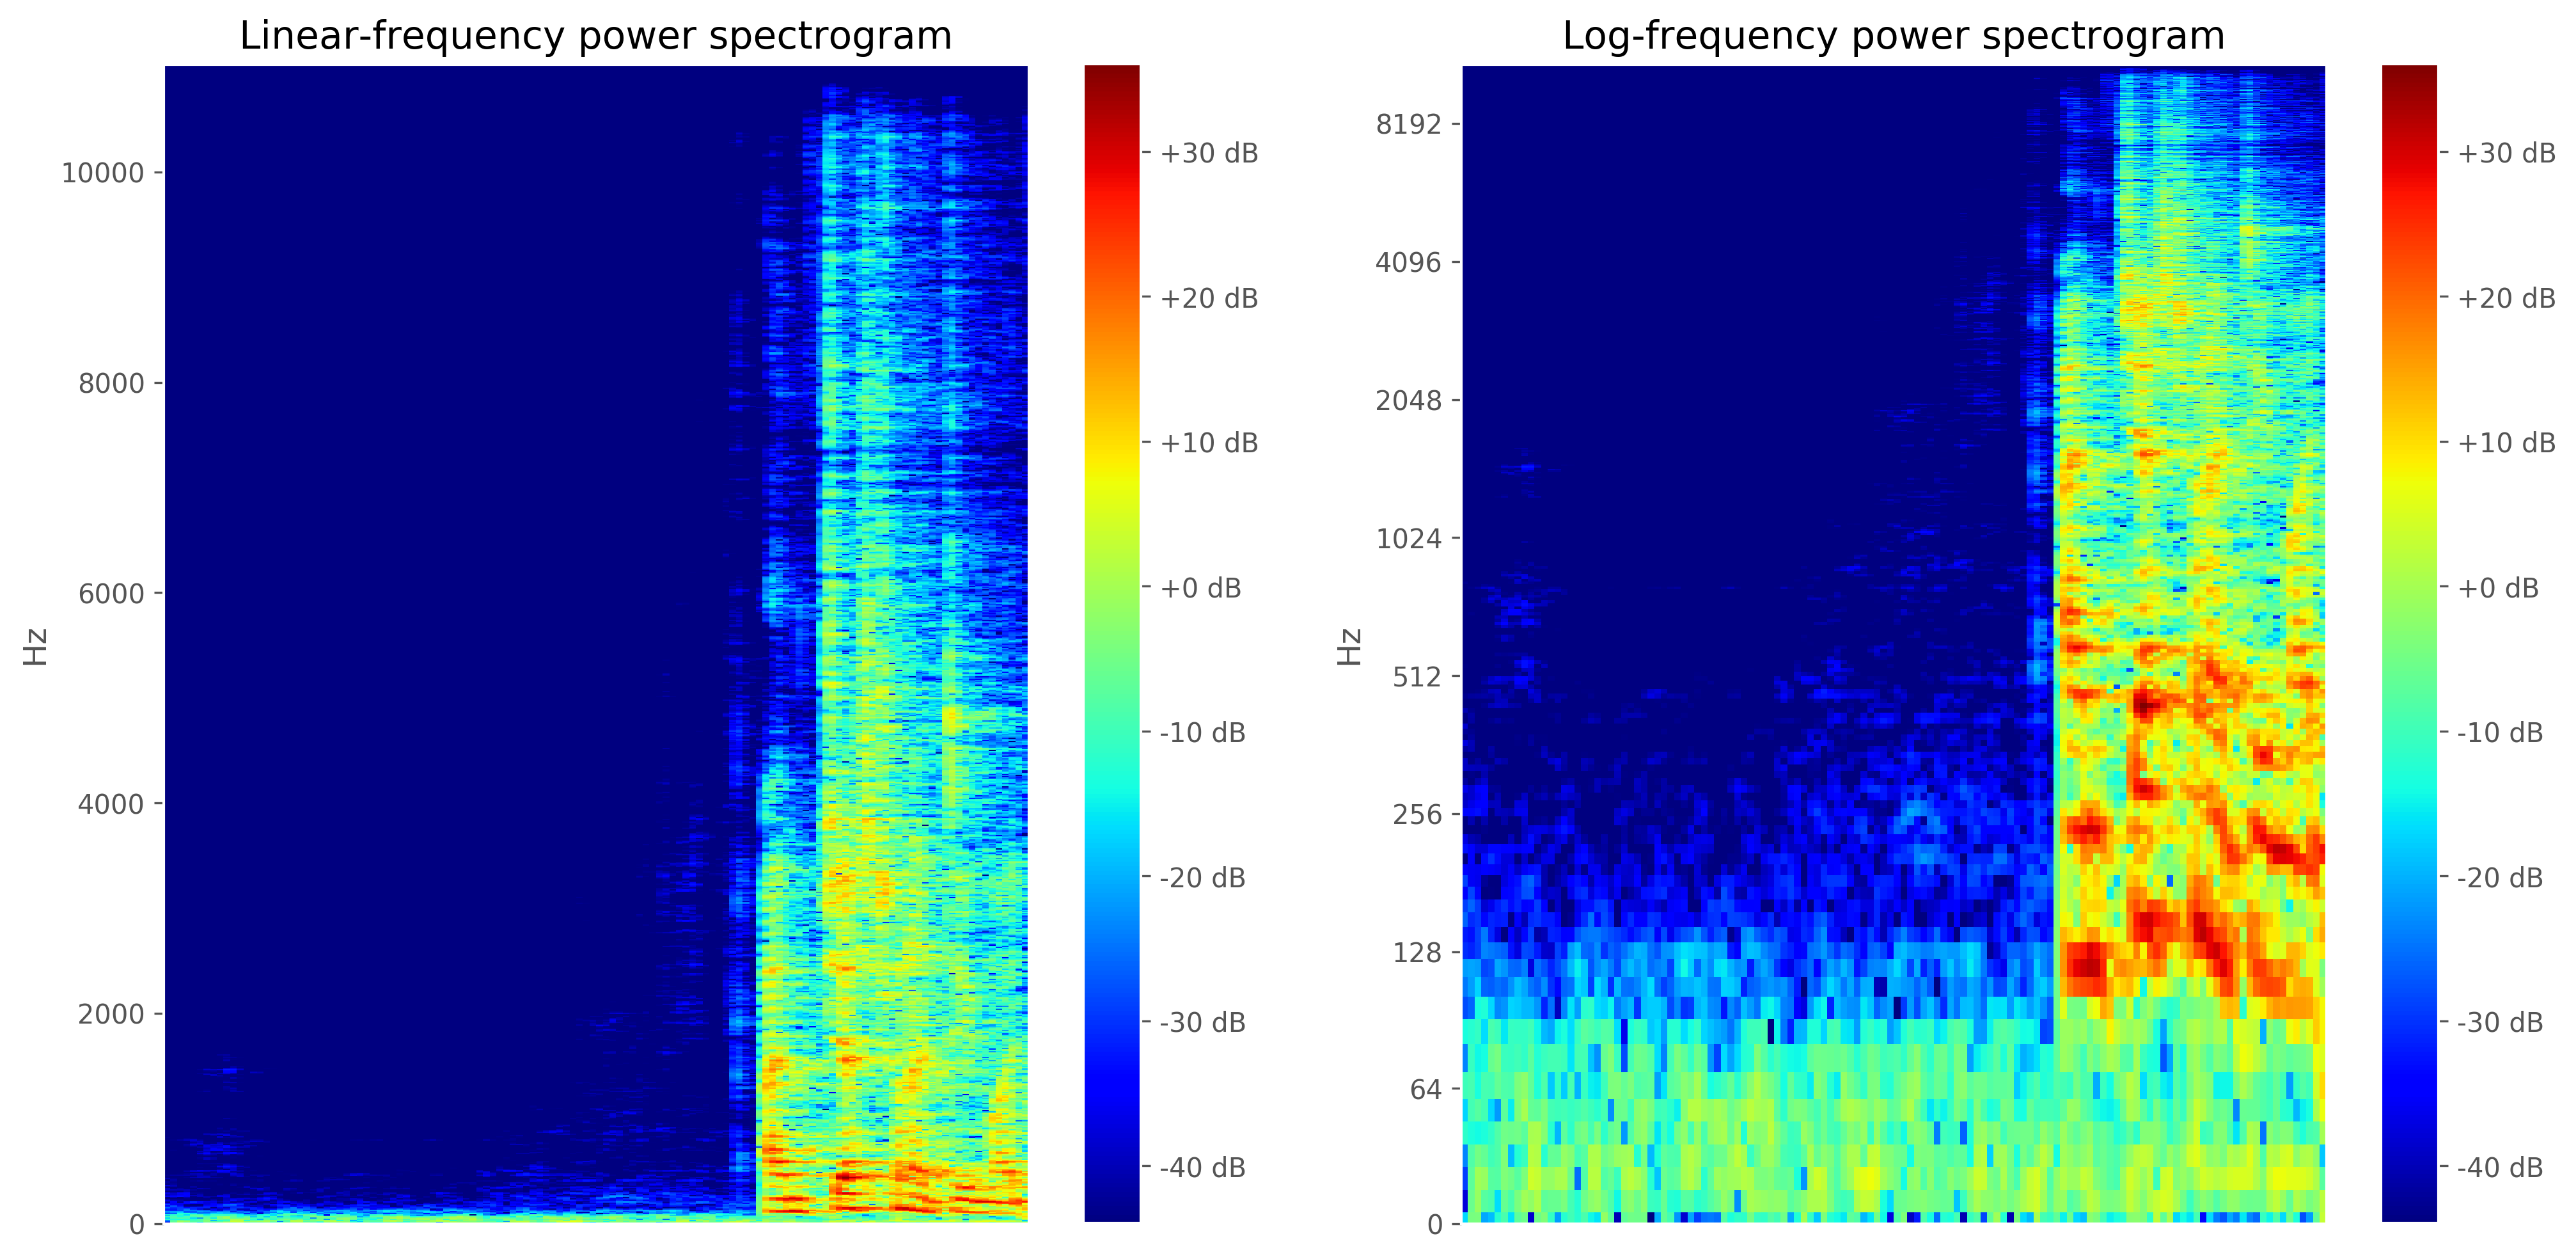

In [66]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=1.0)
plt.figure(figsize=(16, 8), dpi=300)
plt.subplot(1, 2, 1)
specshow(D, y_axis='linear', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.subplot(1, 2, 2)
specshow(D, y_axis='log', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.plot()

In [ ]:
plt.figure(figsize=(8,6), dpi=300)
counts, bins = np.histogram(D, bins=30)
plt.hist(bins[:-1], bins, weights=counts)
plt.ylim([1, 1e5])
plt.yscale('log')
plt.ylabel('count')
plt.xlabel('dB')
plt.title('Histogram')
plt.plot()

In [ ]:
Y = stft(y)
plt.plot(np.sum(np.abs(Y), axis=1))

In [ ]:
Y[:2, :] = 0
plt.plot(np.sum(np.abs(Y), axis=1))

In [ ]:
Y[np.where(np.sum(np.abs(Y), axis=1) >= 10), :] = 0
plt.plot(np.sum(np.abs(Y), axis=1))

In [ ]:
# Y = librosa.util.normalize(Y)

In [ ]:
plt.plot(istft(Y))

In [ ]:
D = librosa.amplitude_to_db(np.abs(Y), ref=1.0)
librosa.display.specshow(D, y_axis='log', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

In [ ]:
newy = istft(Y)

In [ ]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(newy)), ref=1.0)
plt.figure(figsize=(16, 8), dpi=300)
plt.subplot(1, 2, 1)
librosa.display.specshow(D, y_axis='linear', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.subplot(1, 2, 2)
librosa.display.specshow(D, y_axis='log', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.plot()

In [ ]:
plt.figure(figsize=(8,6), dpi=300)
counts, bins = np.histogram(D, bins=30)
plt.hist(bins[:-1], bins, weights=counts)
plt.ylim([1, 1e5])
plt.yscale('log')
plt.ylabel('count')
plt.xlabel('dB')
plt.title('Histogram')
plt.plot()

In [ ]:
y_gt = label_voices[0]
D = librosa.amplitude_to_db(np.abs(librosa.stft(y_gt)), ref=1.0)
plt.figure(figsize=(16, 8), dpi=300)
plt.subplot(1, 2, 1)
librosa.display.specshow(D, y_axis='linear', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.subplot(1, 2, 2)
librosa.display.specshow(D, y_axis='log', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.plot()

In [ ]:
plt.figure(figsize=(8,6), dpi=300)
counts, bins = np.histogram(D, bins=30)
plt.hist(bins[:-1], bins, weights=counts)
plt.ylim([1, 1e5])
plt.yscale('log')
plt.ylabel('count')
plt.xlabel('dB')
plt.title('Histogram')
plt.plot()

In [ ]:
x = data[0][1].cpu().numpy()

In [ ]:
ipd.Audio(data=(newy), rate=22050)

In [ ]:
ipd.Audio(data=(labels[3]), rate=22050)

In [ ]:
ipd.Audio(data=(newy), rate=22050)

In [ ]:
top = np.sum(librosa.util.normalize(outputs[0]) ** 2) / outputs[0].shape[0]
bottom = np.sum(librosa.util.normalize(labels[0]) ** 2) / labels[0].shape[0]

In [ ]:
SDR = 10 * np.log10(top / bottom)

In [ ]:
print(SDR)

In [ ]:
binaural = False
if outputs.shape[0] == 2:
    binaural = True

In [ ]:
import os
base_dir = 'jan24'
os.makedirs(base_dir, exist_ok=True)

In [ ]:
if not binaural:
    for i in range(outputs.shape[0]):
        librosa.output.write_wav('{}/input_{}.wav'.format(base_dir, i), inputs[i], sr=22050)
        librosa.output.write_wav('{}/output_{}.wav'.format(base_dir, i), 100 * outputs[i], sr=22050)
        librosa.output.write_wav('{}/label_{}.wav'.format(base_dir, i), labels[i], sr=22050)
else:
    librosa.output.write_wav('{}/input.wav'.format(base_dir, i), np.asfortranarray(np.vstack(inputs)), sr=22050)
    librosa.output.write_wav('{}/output.wav'.format(base_dir, i), np.asfortranarray(np.vstack(outputs)), sr=22050)
    librosa.output.write_wav('{}/label.wav'.format(base_dir, i), np.asfortranarray(np.vstack(labels)), sr=22050)
        

233 => 1.121
150 => 1.835
100 => 1.036
50 => 0.648